# EVS-POT
Use a function to map the (DH0, n_sigma) to 1D and estimate the probability.


## Read and plot

In [1]:
!ls /cosma/home/do012/dc-he4/anisotropy-flamingo/data/analysis_all/

bf_mc_all.csv			  h0_mc_all.csv
bf_mc_all_scatter.csv		  h0_mc_all_full.csv
bf_mc_zcos.csv			  h0_mc_joint_all.csv
bf_truth.csv			  h0_mc_joint_scatter_all.csv
concatenated_fit_all.csv	  h0_mc_scatter.csv
concatenated_fit_all_mc.csv	  h0_mc_zcos.csv
concatenated_fit_all_scatter.csv  scatter_LX-T_added_scatter.csv
h0_angle_constraint_mc.csv	  scatter_LX-T.csv
h0_angle_constraint_scan.csv	  scatter_M-T.csv
h0_angle_constraints.csv	  scatter_YSZ-T_added_scatter.csv
h0_direct_compare.csv		  scatter_YSZ-T.csv
h0_direct_compare_scatter.csv


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import genpareto
from scipy.special import erfinv
import math
import matplotlib.pyplot as plt
import clusterfit as cf
plt.style.use('./nice.mplstyle')

# Set percentile for EVS threshold
percentile = 95

def calculate_sigma_p_value(proj, target_value):
    median = np.median(proj)
    sigma_84th = np.percentile(proj, 84)
    sigma = sigma_84th - median
    sigma_deviation = np.abs((target_value - median) / sigma)
    p_value_sigma = 1 - math.erf(sigma_deviation / np.sqrt(2))
    return sigma_deviation, p_value_sigma

# Function to calculate EVT p-value
def calculate_evt_p_value(proj, target_value, percentile):
    # Determine the threshold
    threshold = np.percentile(proj, percentile)
    exceedances = proj[proj > threshold] - threshold  # Tail data

    # Fit GPD to the tail data
    params = genpareto.fit(exceedances)

    # Tail survival probability (proportion of data in the tail)
    tail_prob = np.sum(proj >= threshold) / len(proj)

    if target_value > threshold:
        # Conditional probability adjusted to match at the threshold
        p_value_evt = (1 - genpareto.cdf(target_value - threshold, *params)) * tail_prob
    else:
        # Empirical CDF for the bulk region
        p_value_evt = np.sum(proj >= target_value) / len(proj)

    # Transform to sigma (Gaussian equivalent deviation)
    sigma_evt = np.sqrt(2) * erfinv(1 - p_value_evt)

    return p_value_evt, sigma_evt


# The first projection function
def default_proj(y, n_sigma):
    return y - y / n_sigma


In [5]:
def __calc_and_plot():
    """ Interior function to avoid copy pasting the same procedure 100 times."""

    # Number of sigma deviation
    sigma_deviation, p_value_sigma = calculate_sigma_p_value(x, target_value)
    print(f"Number of std deviation: p={p_value_sigma:.3g}\\,({sigma_deviation:.3g}\\sigma)")

    # Calculate EVT p-value and sigma deviation
    p_value_evt, sigma_evt = calculate_evt_p_value(x, target_value, percentile=percentile)
    print(f"EVT p-value: p={p_value_evt:.3g}\\,({sigma_evt:.3g}\\sigma)")

    # Plotting results
    fig = plt.figure(figsize=(5, 3))
    plt.hist(x, bins=30, density=True, alpha=0.6, color='#7570b3', label='FLAMINGO')

    # Fit a GPD distribution
    threshold = np.percentile(x, percentile)
    exceedances = x[x > threshold] - threshold
    params = genpareto.fit(exceedances)
    shape, loc, scale = params

    # Plot fitted distribution
    x_vals = np.linspace(threshold, x.max(), 100)
    gpd_pdf = genpareto.pdf(x_vals - threshold, shape, loc, scale) * (1 - percentile / 100)
    plt.axvline(target_value, color='red', linestyle='-', label='Migkas+21')
    plt.plot(x_vals[1:], gpd_pdf[1:], color='g', label='Fitted GPD (Tail)')
    plt.axvline(threshold, color='blue', linestyle='--', label='Threshold (90th Percentile)')

    # Annotate the plot
    plt.annotate(f'p={p_value_evt:.2e}', 
                xy=(target_value, 0.2), xycoords='data',
                xytext=(target_value - 1, 0.2), textcoords='data',
                arrowprops=dict(arrowstyle='->,head_width=.15', color='red'),
                horizontalalignment='right', verticalalignment='center', color='red')

    plt.xlabel('$x$')
    plt.ylabel('Density')
    plt.legend(fontsize=9)

    return fig

## Lx-T
z = 0.07, 0.10

In [19]:
# Load the data
data = pd.read_csv('../data/analysis_all/bf_mc_all.csv')

# Filter data for zmax = 0.07
zmask = data['zmax'] == 0.07
seg = data[zmask][data['scaling_relation'] == 'LX-T'][['ubf', 'ubf_err_lower']]

# Calculate the projection values
x = seg['ubf'].values - seg['ubf_err_lower'].values

# Define the target value
target_value = 1100 - 410

/tmp/ipykernel_1473107/3341492423.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seg = data[zmask][data['scaling_relation'] == 'LX-T'][['ubf', 'ubf_err_lower']]


Number of std deviation: p=0.00629\,(2.73\sigma)
EVT p-value: p=0.00669\,(2.71\sigma)


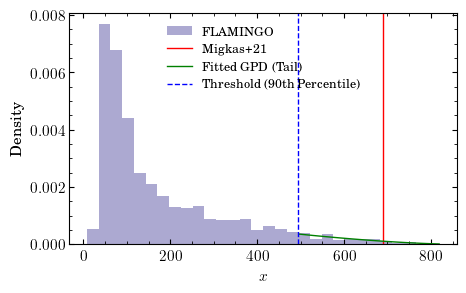

In [20]:
fig = __calc_and_plot()
# plt.savefig(f'./to_paper/evs_mcmc_bulk_flow.pdf', bbox_inches='tight')   # save the figure
plt.show()

In [21]:
# Load the data
data = pd.read_csv('../data/analysis_all/bf_mc_all.csv')

# Filter data for zmax = 0.10
zmask = data['zmax'] == 0.10
seg = data[zmask][data['scaling_relation'] == 'LX-T'][['ubf', 'ubf_err_lower']]

# Calculate the projection values
x = seg['ubf'].values - seg['ubf_err_lower'].values

# Define the target value
target_value = 1080 - 380

/tmp/ipykernel_1473107/3587435354.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seg = data[zmask][data['scaling_relation'] == 'LX-T'][['ubf', 'ubf_err_lower']]


Number of std deviation: p=0.00688\,(2.7\sigma)
EVT p-value: p=0.00582\,(2.76\sigma)


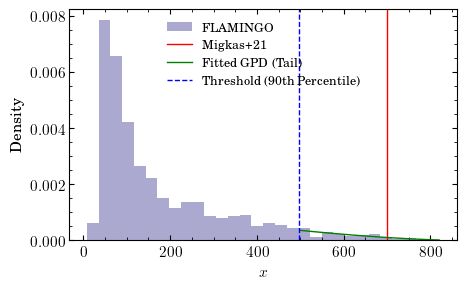

In [22]:
fig = __calc_and_plot()
# plt.savefig(f'./to_paper/evs_mcmc_bulk_flow.pdf', bbox_inches='tight')   # save the figure
plt.show()

## Ysz-T
z = 0.07, 0.10

In [23]:
# Load the data
data = pd.read_csv('../data/analysis_all/bf_mc_all.csv')

# Filter data for zmax = 0.07
zmask = data['zmax'] == 0.07
seg = data[zmask][data['scaling_relation'] == 'YSZ-T'][['ubf', 'ubf_err_lower']]

# Calculate the projection values
x = seg['ubf'].values - seg['ubf_err_lower'].values

# Define the target value
target_value = 1060 - 390

/tmp/ipykernel_1473107/1489050425.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seg = data[zmask][data['scaling_relation'] == 'YSZ-T'][['ubf', 'ubf_err_lower']]


Number of std deviation: p=0\,(9\sigma)
EVT p-value: p=3.23e-06\,(4.66\sigma)


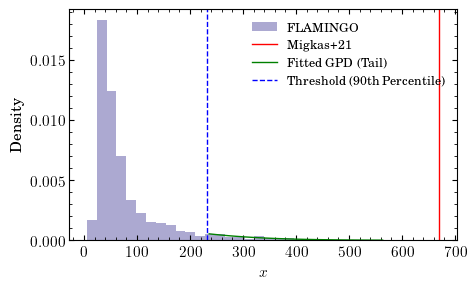

In [24]:
fig = __calc_and_plot()
# plt.savefig(f'./to_paper/evs_mcmc_bulk_flow.pdf', bbox_inches='tight')   # save the figure
plt.show()

In [25]:
# Load the data
data = pd.read_csv('../data/analysis_all/bf_mc_all.csv')

# Filter data for zmax = 0.10
zmask = data['zmax'] == 0.10
seg = data[zmask][data['scaling_relation'] == 'YSZ-T'][['ubf', 'ubf_err_lower']]

# Calculate the projection values
x = seg['ubf'].values - seg['ubf_err_lower'].values

# Define the target value
target_value = 1020 - 380

/tmp/ipykernel_1473107/866662658.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seg = data[zmask][data['scaling_relation'] == 'YSZ-T'][['ubf', 'ubf_err_lower']]


Number of std deviation: p=0\,(8.8\sigma)
EVT p-value: p=3.45e-06\,(4.64\sigma)


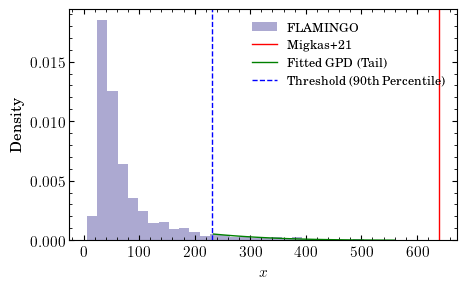

In [26]:
fig = __calc_and_plot()
# plt.savefig(f'./to_paper/evs_mcmc_bulk_flow.pdf', bbox_inches='tight')   # save the figure
plt.show()

## Joint of LT, YT

In [12]:
# Load the data
data = pd.read_csv('../data/analysis_all/bf_mc_all.csv')

# Filter data for zmax = 0.07
zmask = data['zmax'] == 0.07
uLT = data[zmask][data['scaling_relation'] == 'LX-T'][['Lightcone', 'ubf', 'ubf_err_lower', 'vlat', 'vlon']]
uYT = data[zmask][data['scaling_relation'] == 'YSZ-T'][['Lightcone', 'ubf', 'ubf_err_lower', 'vlat', 'vlon']]

# Merge the data on Lightcone
u = pd.merge(left=uLT, right=uYT, on='Lightcone', suffixes=('_LT', '_YT'))

# Calculate the projection values
theta = cf.angular_separation(u['vlon_LT'].values, u['vlat_LT'].values,
    u['vlon_YT'].values, u['vlon_YT'].values) * np.pi/180
x = (u['ubf_LT'].values - u['ubf_err_lower_LT'].values) * np.cos(theta / 2) +\
    (u['ubf_YT'].values - u['ubf_err_lower_YT'].values) * np.cos(theta / 2)
x /= 2

# Define the target value
th = cf.angular_separation(318, -5, 254, -17) * np.pi/180
target_value = (1100 - 410) * np.cos(th / 2) + (1060 - 390) * np.cos(th / 2)
target_value /= 2

/tmp/ipykernel_1503580/2125801755.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  uLT = data[zmask][data['scaling_relation'] == 'LX-T'][['Lightcone', 'ubf', 'ubf_err_lower', 'vlat', 'vlon']]
/tmp/ipykernel_1503580/2125801755.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  uYT = data[zmask][data['scaling_relation'] == 'YSZ-T'][['Lightcone', 'ubf', 'ubf_err_lower', 'vlat', 'vlon']]


Number of std deviation: p=7.29e-10\,(6.16\sigma)
EVT p-value: p=5.04e-05\,(4.05\sigma)


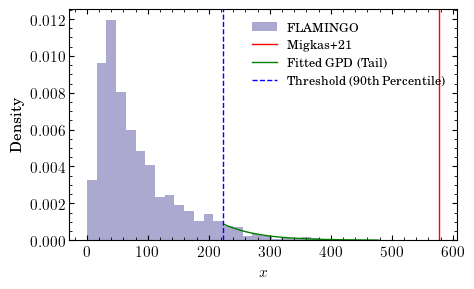

In [13]:
fig = __calc_and_plot()
# plt.savefig(f'./to_paper/evs_mcmc_bulk_flow.pdf', bbox_inches='tight')   # save the figure
plt.show()

## Joint of LT YT

In [14]:
# Load the data
data = pd.read_csv('../data/analysis_all/bf_mc_all.csv')

# Filter data for zmax = 0.10
zmask = data['zmax'] == 0.10
uLT = data[zmask][data['scaling_relation'] == 'LX-T'][['Lightcone', 'ubf', 'ubf_err_lower', 'vlat', 'vlon']]
uYT = data[zmask][data['scaling_relation'] == 'YSZ-T'][['Lightcone', 'ubf', 'ubf_err_lower', 'vlat', 'vlon']]

# Merge the data on Lightcone
u = pd.merge(left=uLT, right=uYT, on='Lightcone', suffixes=('_LT', '_YT'))

# Calculate the projection values
theta = cf.angular_separation(u['vlon_LT'].values, u['vlat_LT'].values,
    u['vlon_YT'].values, u['vlon_YT'].values) * np.pi/180
x = (u['ubf_LT'].values - u['ubf_err_lower_LT'].values) * np.cos(theta / 2) +\
    (u['ubf_YT'].values - u['ubf_err_lower_YT'].values) * np.cos(theta / 2)
x /= 2

# Define the target value
th = cf.angular_separation(257, -28, 322, -13) * np.pi/180
target_value = (1080-380) * np.cos(th / 2) + (1020-380) * np.cos(th / 2)
target_value /= 2

/tmp/ipykernel_1503580/1924115775.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  uLT = data[zmask][data['scaling_relation'] == 'LX-T'][['Lightcone', 'ubf', 'ubf_err_lower', 'vlat', 'vlon']]
/tmp/ipykernel_1503580/1924115775.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  uYT = data[zmask][data['scaling_relation'] == 'YSZ-T'][['Lightcone', 'ubf', 'ubf_err_lower', 'vlat', 'vlon']]


Number of std deviation: p=1.18e-09\,(6.08\sigma)
EVT p-value: p=4.5e-05\,(4.08\sigma)


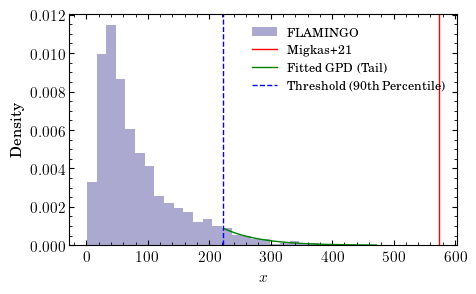

In [15]:
fig = __calc_and_plot()
# plt.savefig(f'./to_paper/evs_mcmc_bulk_flow.pdf', bbox_inches='tight')   # save the figure
plt.show()